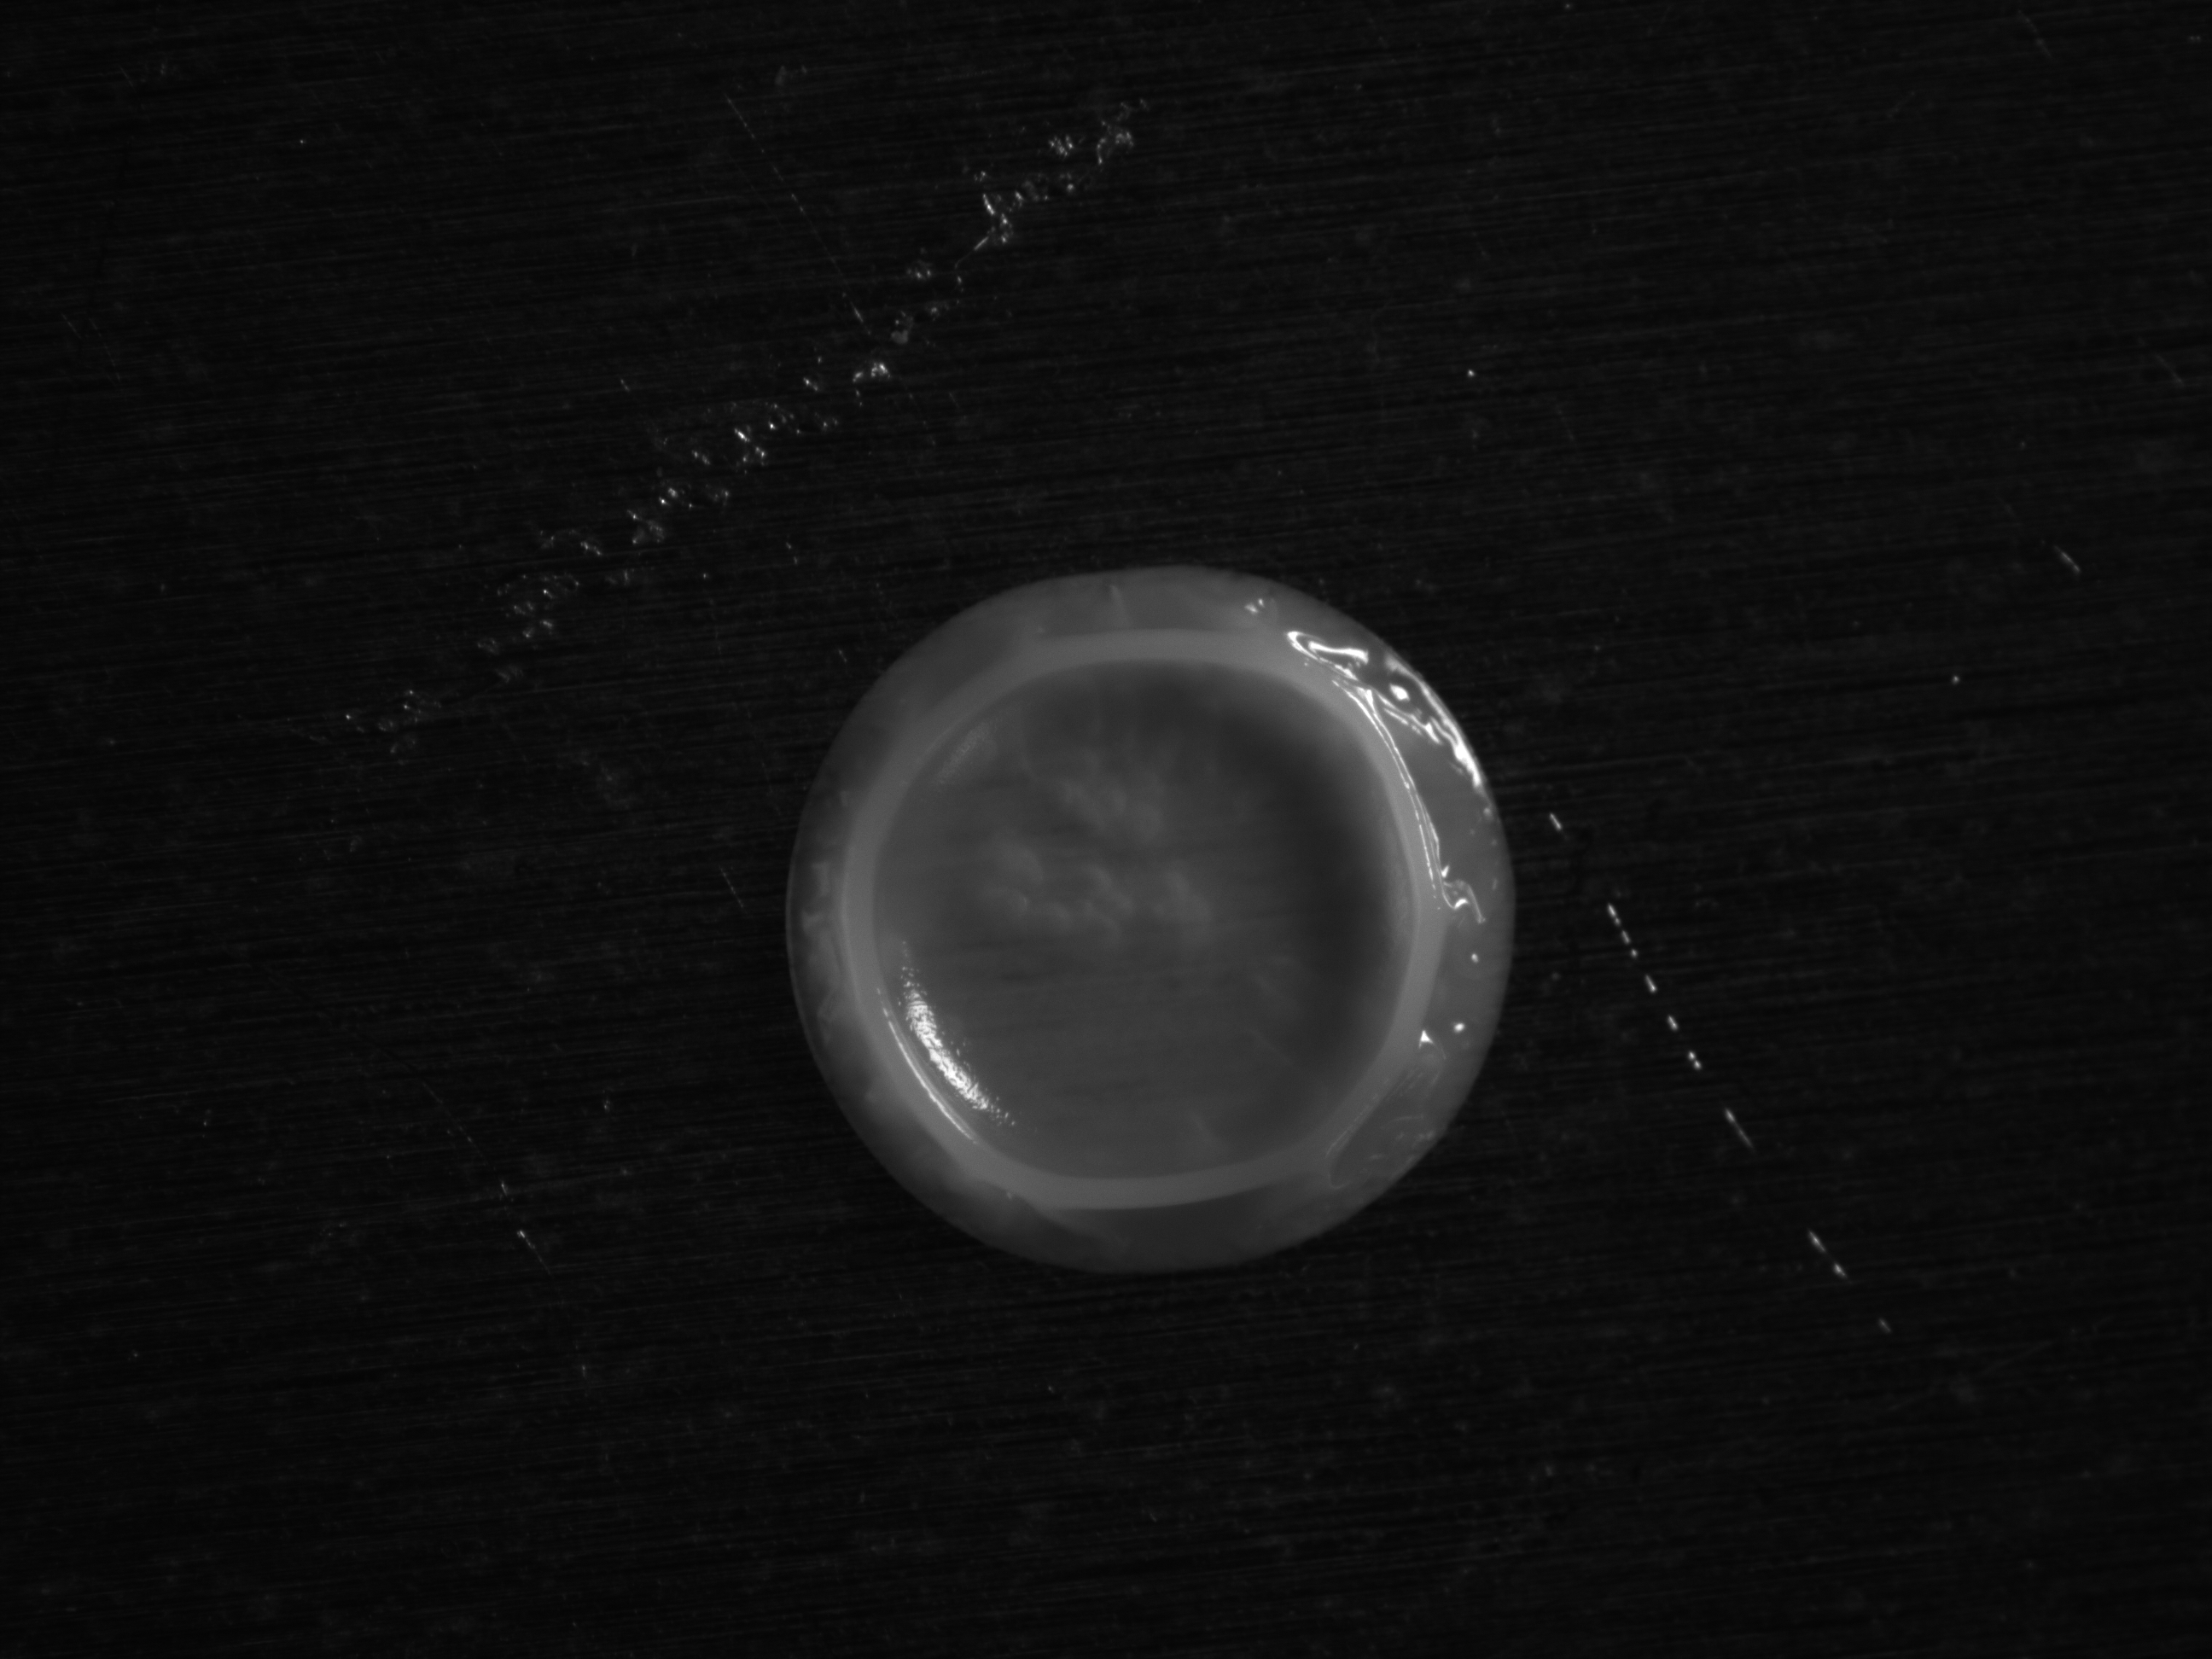

In [5]:
#Cropping an Image in a circular way using Python

import numpy as np
from PIL import Image, ImageDraw
  
  
img = Image.open('../data/raw/dn/DBM_50uL_70C_C1_a.bmp')
display(img)

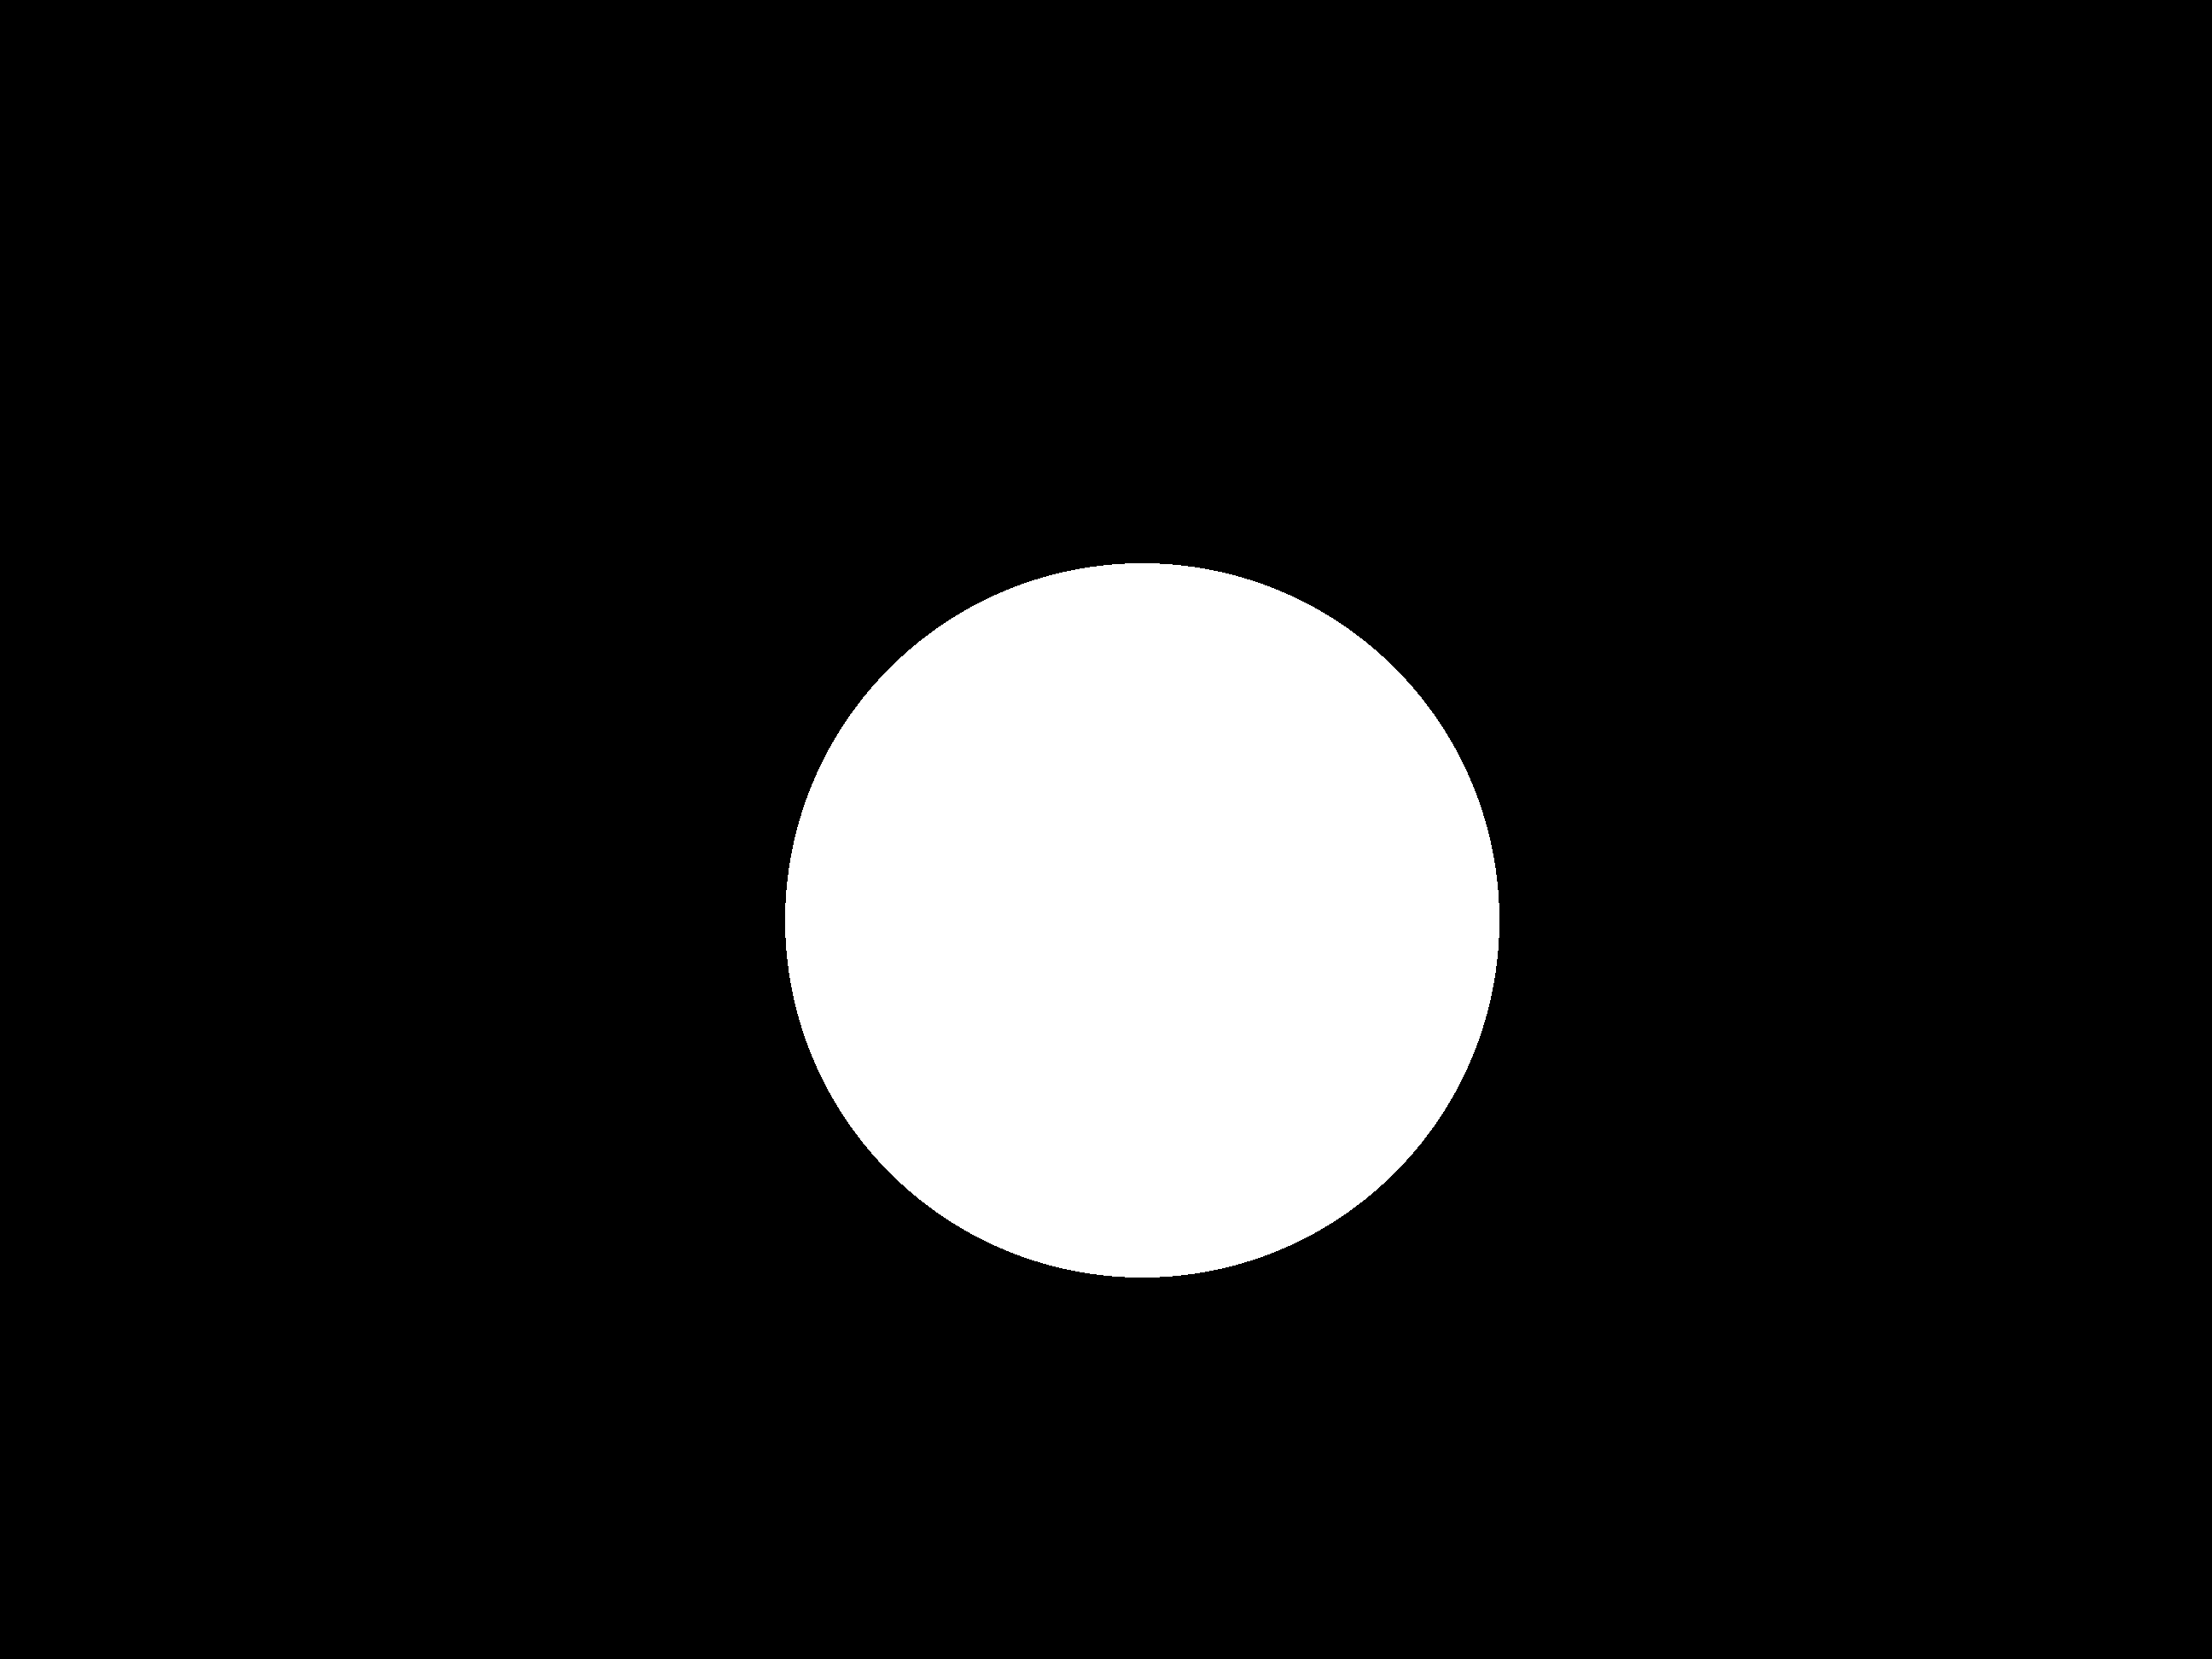

In [6]:
h,w = img.size
  
# creating luminous image
lum_img = Image.new('L',[h,w] ,0) 
draw = ImageDraw.Draw(lum_img)
# draw.pieslice([(0,0),(h,w)],0,360,fill=255)
x = 1338
y = 1078
r = 418
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, fill=255)
# draw.regular_polygon((1338, 1078, 418),n_sides=6, rotation=0, fill=255)
img_arr = np.array(img)
lum_img_arr = np.array(lum_img)
display(Image.fromarray(lum_img_arr))

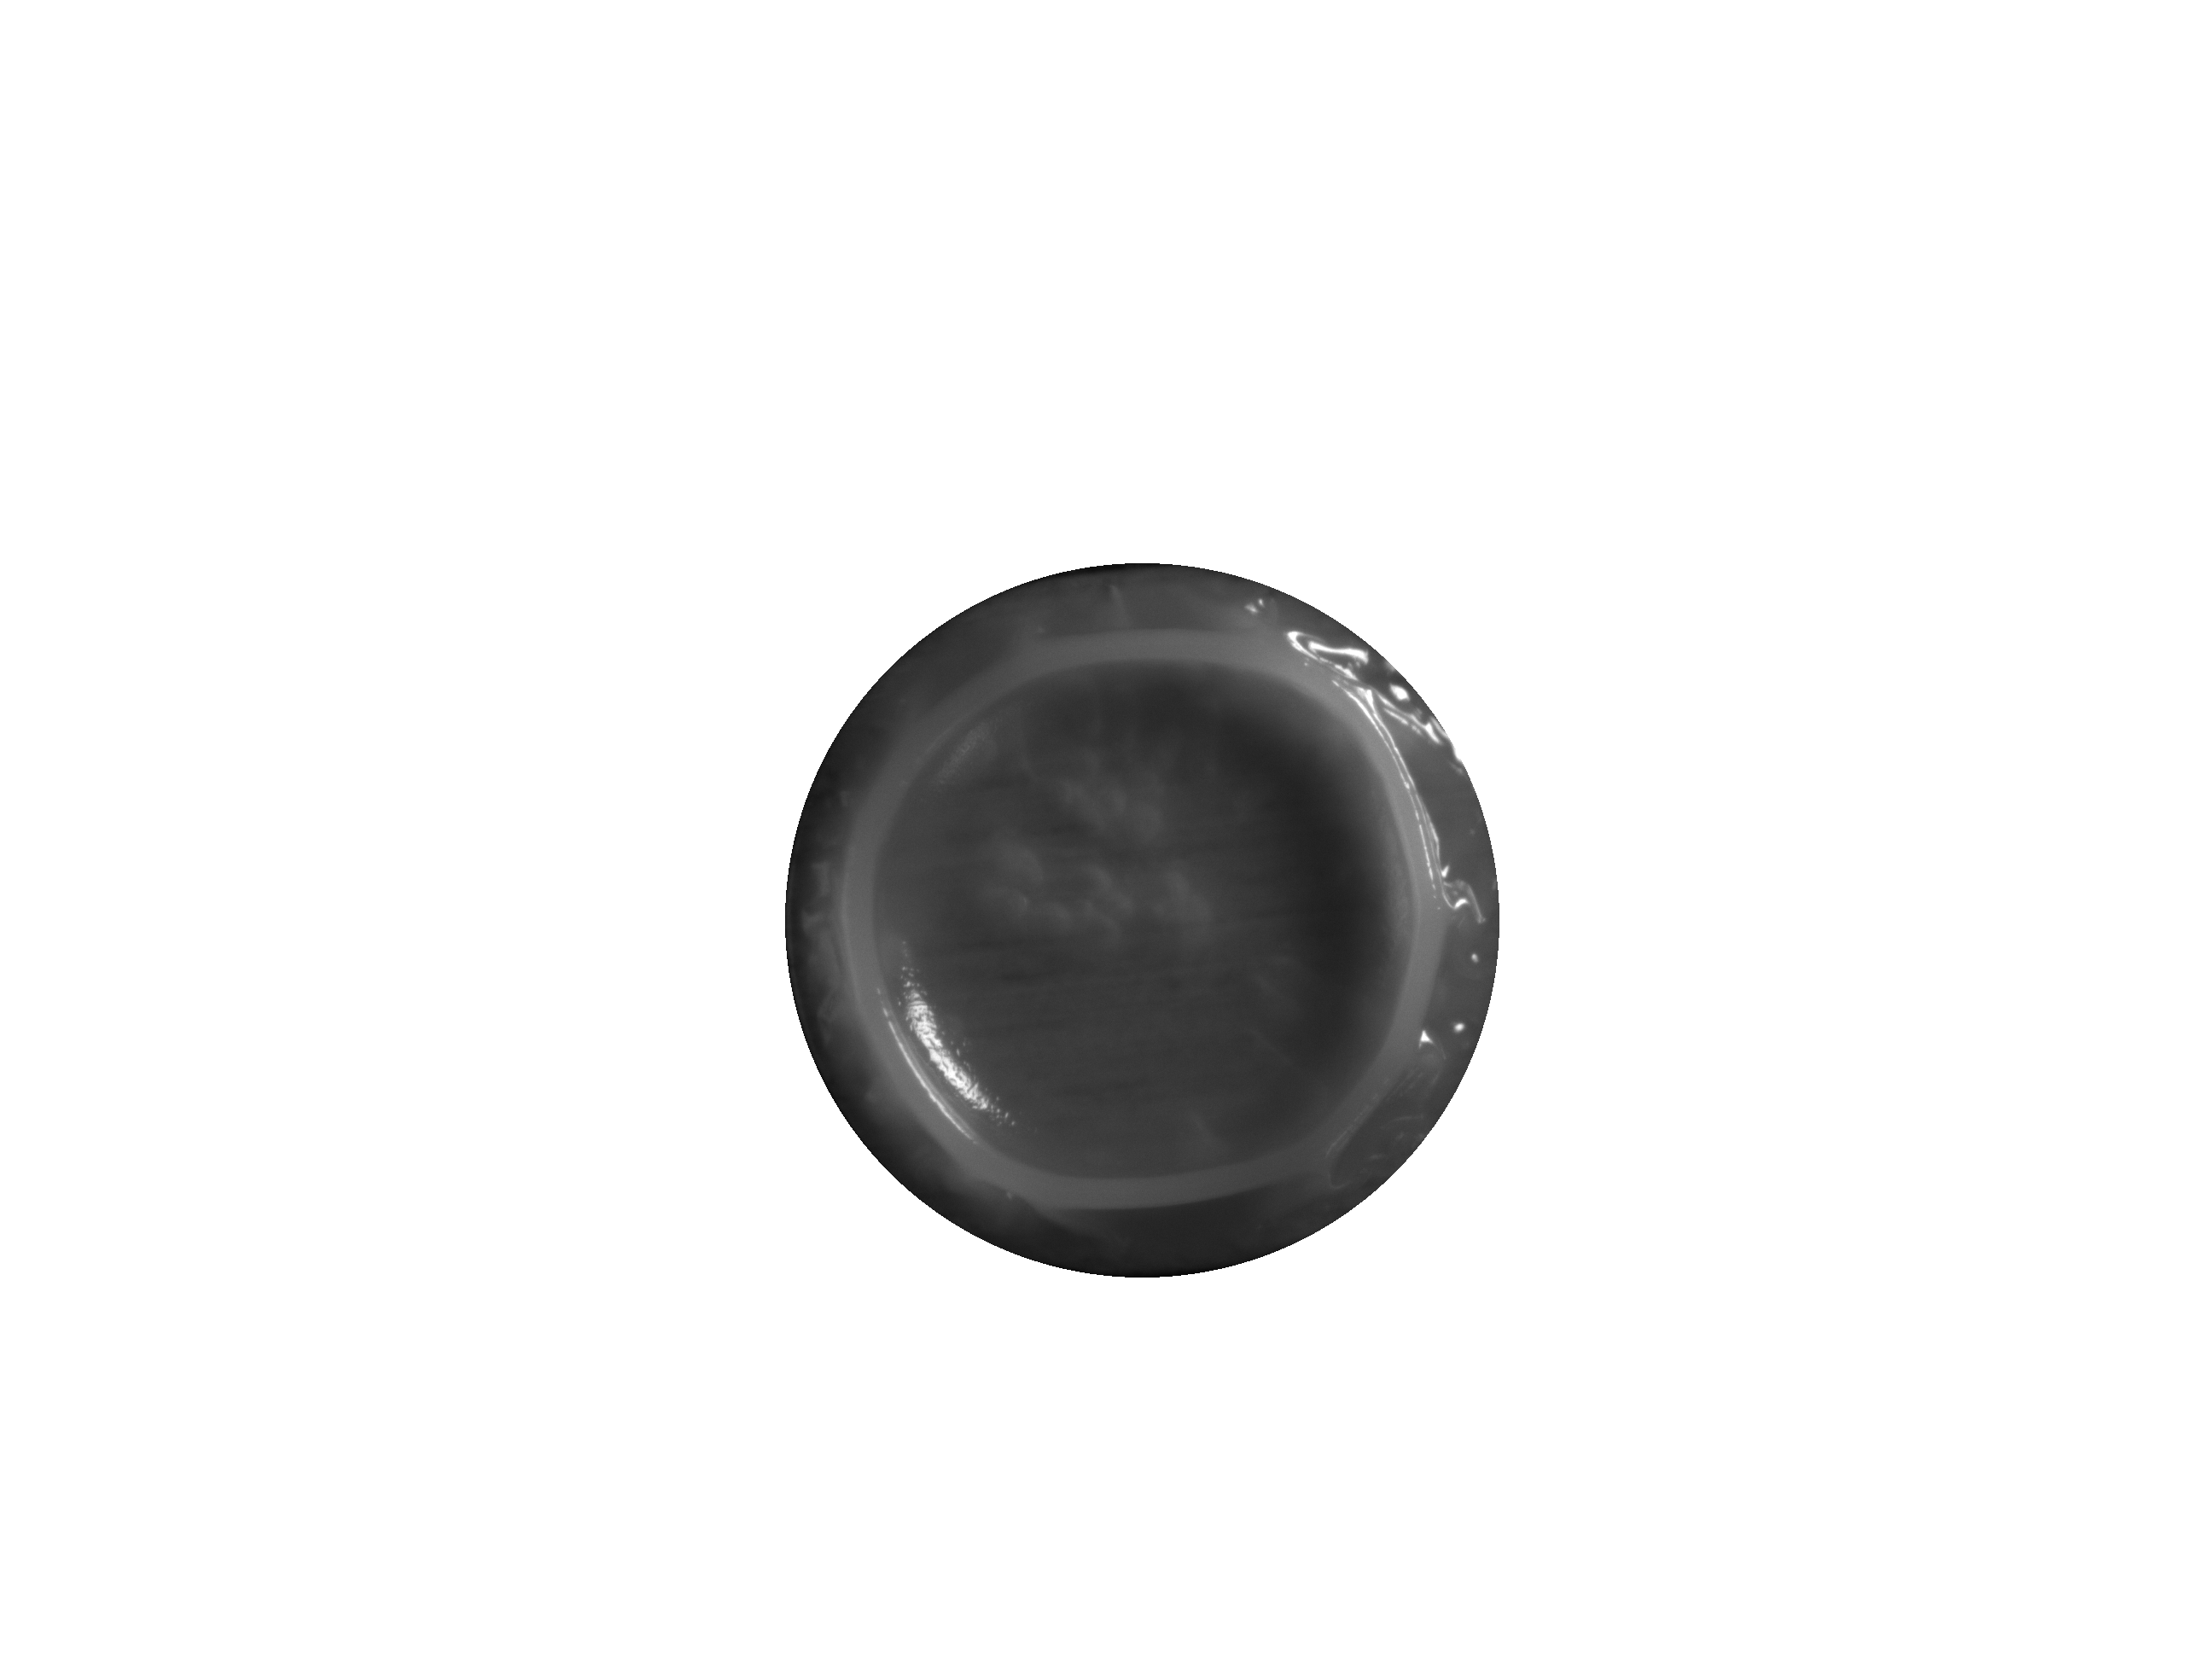

In [7]:
final_img_arr = np.dstack((img_arr, lum_img_arr))
display(Image.fromarray(final_img_arr))

In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def detect_circles(pil_image):

    open_cv_image = np.array(pil_image.convert('RGB')) 
    # Convert RGB to BGR 
    img = open_cv_image[:, :, ::-1].copy() 
#     img = cv2.cv.CreateImageHeader(pimg.size,cv2.IPL_DEPTH_8U,3)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = np.asarray(img)
    plt.imshow(gray)
    plt.show()
    blurred = cv2.medianBlur(gray, 25) #cv2.bilateralFilter(gray,10,50,50)

    minDist = 150
    param1 = 30 #500
    param2 = 50 #200 #smaller value-> more false circles
    minRadius = 0
    maxRadius = 0 #10

    # docstring of HoughCircles: HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
#     circles = cv2.HoughCircles(blurred,cv2.HOUGH_GRADIENT,1,60,param1=50,param2=30,minRadius=0,maxRadius=0)
#     circles = cv2.HoughCircles(blurred,cv2.HOUGH_GRADIENT,1,minDist,param1=50,param2=30,minRadius=0,maxRadius=0)

    print('circles are ', circles)
    # Red color in BGR
#     color = (0, 0, 255)
    color = (255, 0, 0)
    # Line thickness of -1 px
    thickness = 10
  
    # Using cv2.circle() method
    # Draw a circle of red color of thickness -1 px
#     image = cv2.circle(image, center_coordinates, radius, color, thickness)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        num = 1
        for i in circles[0,:]:
            print('i is ', i)
            num = num + 1
            cv2.circle(img, (i[0], i[1]), i[2], color, num)
            cv2.circle(img,(i[0],i[1]),20,color,3)
#             if if_inner:
#                 cv2.circle(img, (i[0], i[1]), i[2]-150, color, num * thickness)

    # Show result for testing:
    # cv2.imshow('img', img)
    plt.imshow(img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

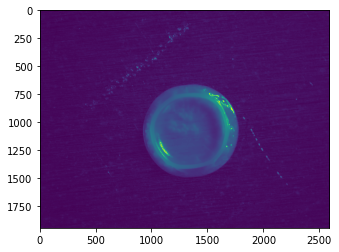

circles are  [[[1338.5 1077.5  418.2]]]
i is  [1338 1078  418]


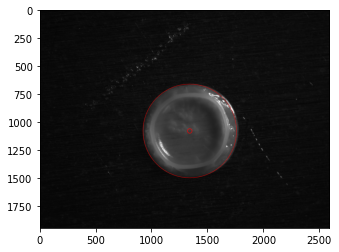

In [9]:
detect_circles(Image.fromarray(final_img_arr))

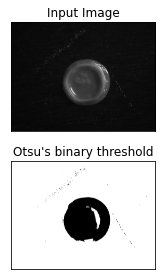

In [11]:
# SEGMENTATION
import numpy as np
import cv2
from matplotlib import pyplot as plt
#img = cv2.imread(r'../data/raw/dn/DBM_50uL_70C_C1_a.bmp')
open_cv_image = np.array(Image.fromarray(final_img_arr).convert('RGB')) 
    # Convert RGB to BGR 
img = open_cv_image[:, :, ::-1].copy() 
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),120,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.subplot(211),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(thresh, 'gray')
plt.imsave(r'thresh.png',thresh)
plt.title("Otsu's binary threshold"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

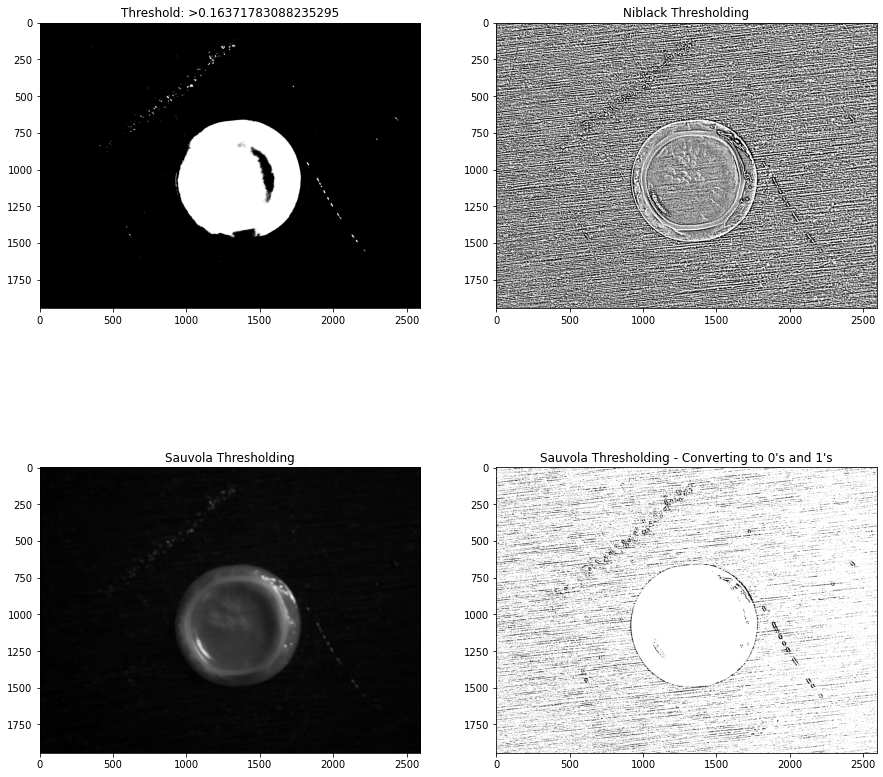

In [18]:
# Importing necessary libraries
# https://www.geeksforgeeks.org/image-segmentation-using-pythons-scikit-image-module/#:~:text=The%20process%20of%20splitting%20images,image%20from%20its%20integration%20level.
from skimage import data, io
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
 
# Setting plot size to 15, 15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
# coffee = io.imread('../data/raw/dn/DBM_50uL_70C_C1_a.bmp')
coffee = np.array(Image.fromarray(final_img_arr).convert('RGB')) 
# coffee = data.coffee()
gray_coffee = rgb2gray(coffee)
 
# Computing Otsu's thresholding value
threshold = filters.threshold_otsu(gray_coffee)
 
# Computing binarized values using the obtained
# threshold
binarized_coffee = (gray_coffee > threshold)*1
plt.subplot(2,2,1)
plt.title("Threshold: >"+str(threshold))
 
# Displaying the binarized image
plt.imshow(binarized_coffee, cmap = "gray")
 
# Computing Ni black's local pixel
# threshold values for every pixel
threshold = filters.threshold_niblack(gray_coffee)
 
# Computing binarized values using the obtained
# threshold
binarized_coffee = (gray_coffee > threshold)*1
plt.subplot(2,2,2)
plt.title("Niblack Thresholding")
 
# Displaying the binarized image
plt.imshow(binarized_coffee, cmap = "gray")
 
# Computing Sauvola's local pixel threshold
# values for every pixel - Not Binarized
threshold = filters.threshold_sauvola(gray_coffee)
plt.subplot(2,2,3)
plt.title("Sauvola Thresholding")
 
# Displaying the local threshold values
plt.imshow(threshold, cmap = "gray")
 
# Computing Sauvola's local pixel
# threshold values for every pixel - Binarized
binarized_coffee = (gray_coffee > threshold)*1
plt.subplot(2,2,4)
plt.title("Sauvola Thresholding - Converting to 0's and 1's")
 
# Displaying the binarized image
plt.imshow(binarized_coffee, cmap = "gray")

In [24]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data, img_as_float
from skimage.segmentation import chan_vese

def chan_vese_segment(file_name):
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Sample Image of scikit-image package
    astronaut = io.imread(file_name)
    # '../data/raw/dn/DBM_50uL_70C_C1_a.bmp')
    gray_astronaut = rgb2gray(astronaut)

    # Computing the Chan VESE segmentation technique
    chanvese_gray_astronaut = chan_vese(gray_astronaut,
                                        max_iter=100,
                                        extended_output=True)

    ax = axes.flatten()

    # Plotting the original image
    ax[0].imshow(gray_astronaut, cmap="gray")
    ax[0].set_title("Original Image")

    # Plotting the segmented - 100 iterations image
    ax[1].imshow(chanvese_gray_astronaut[0], cmap="gray")
    title = "Chan-Vese segmentation - {} iterations"
    format(len(chanvese_gray_astronaut[2]))

    ax[1].set_title(title)

    # Plotting the final level set
    ax[2].imshow(chanvese_gray_astronaut[1], cmap="gray")
    ax[2].set_title("Final Level Set")
    plt.show()

/var/folders/mg/pccyc4ld2433fc6qddtspnrr0000gn/T/ipykernel_11877/3407607734.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_astronaut = rgb2gray(astronaut)


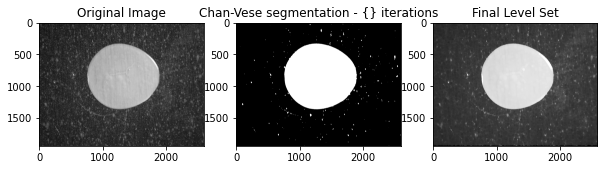

In [25]:
chan_vese_segment('../data/raw/pc/220208b_C1.bmp')

/var/folders/mg/pccyc4ld2433fc6qddtspnrr0000gn/T/ipykernel_11877/3407607734.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_astronaut = rgb2gray(astronaut)


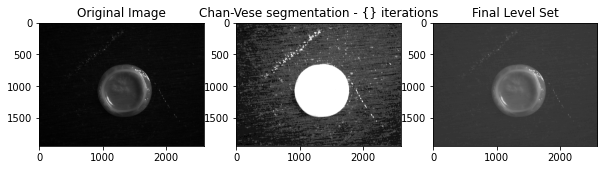

In [26]:
chan_vese_segment('../data/raw/dn/DBM_50uL_70C_C1_a.bmp')